# Heat islands generator

The purpose of this notebook is to provide the necessary tooling for generating synthetic data that will be used to train the heat islands detection model.

A heat island, in this example, is arbitrarly defined as a map with at least 30% of its area being hot or very hot.

In [74]:
# let's start by importing the libraries we will need
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import random
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [75]:
# now we want to define the function that will generate images
def generate_image():
    # output image width and height
    width, height = 256, 256

    # creating an empty image with a black background
    image = Image.new('RGB', (width, height), 'black')
    draw = ImageDraw.Draw(image)

    # randomly generated heat centers coordinates
    num_heat_centers = random.randint(5, 15)
    heat_centers = [(random.randint(0, width - 1), random.randint(0, height - 1)) for _ in range(num_heat_centers)]

    # randomly generate heat centers temperatures (with a max value of 1)
    heat_centers_temperatures = [random.uniform(0.5, 1.0) for _ in range(num_heat_centers)]

    map_avg_pixel_temperature = random.uniform(0, 0.5)

    # generating temperature variations for each pixel
    for x in range(width):
        # calculating pixel temperature
        for y in range(height):
            pixel_temperatures_from_heat_centers = [0 for _ in range(num_heat_centers)]
            for i, (heat_center_x, heat_center_y) in enumerate(heat_centers):
                # Euclidian distance between the pixel and the heat center
                distance = ((x - heat_center_x) ** 2 + (y - heat_center_y) ** 2) ** 0.5
                pixel_temperatures_from_heat_centers[i] = heat_centers_temperatures[i] * max(0, 1 - distance / 50)  # adjust the denominator to adjust the spread of the heat island
            
            # generating a random temperature for the normal zone
            pixel_temperature = random.uniform(map_avg_pixel_temperature, 1.0)

            # computing final temperature of the pixel by combining the temperatures from the heat centers with the pixel initial temperature
            pixel_hot_temperature = sum(pixel_temperatures_from_heat_centers)
            pixel_temperature = (pixel_hot_temperature + pixel_temperature) / 2

            # defining the color of the pixel based on its temperature
            if pixel_temperature <= 0.2:
                color = (0, 0, 255)  # blue (cold)
            elif pixel_temperature <= 0.4:
                color = (0, 128, 0)  # green (a bit cold)
            elif pixel_temperature <= 0.6:
                color = (255, 255, 0)  # yellow (a bit hot)
            elif pixel_temperature <= 0.8:
                color = (255, 165, 0)  # orange (hot)
            else:
                color = (255, 0, 0)  # red (very hot)

            # drawing the pixel with the calculated color
            draw.point((x, y), fill=color)
            
    # deciding arbitrarly that we are in a presence of a heat island if at leat 30% of the pixels are hot or very hot
    if sum([1 for pixel in image.getdata() if pixel == (255, 0, 0) or pixel == (255, 165, 0)]) / (width * height) >= 0.3:
        label = 1
    else:
        label = -1

    return image, label

(-0.5, 255.5, 255.5, -0.5)

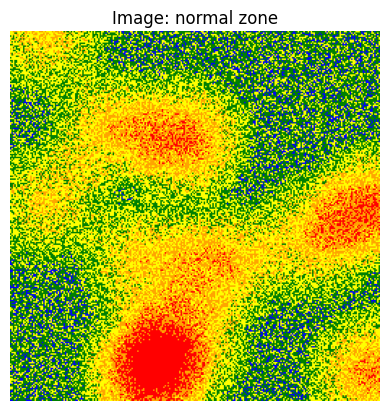

In [76]:
# let's try this function and have a look
image, label = generate_image()

plt.figure()
plt.imshow(image)
if label == 1:
    plt.title(f'Image: heat island')
else:
    plt.title(f'Image: normal zone')
plt.axis('off')

## Creating synthetic data

In [77]:
# creating the images and their labels
num_images_to_generate = 50

images = []
labels = []

for _ in range(num_images_to_generate):
    image, label = generate_image()
    images.append(image)
    labels.append(label)

In [78]:
# turning the images into one-dimensional numpy arrays
image_vectors = []
for image in images:
    image_vector = np.array(image).reshape(-1)
    image_vectors.append(image_vector)

# creating a dataset with,
# x being the images independent variables (the pixels),
# y being the images dependent variables (the labels)
x = np.array(image_vectors)
y = np.array(labels)

# creating test and training data,
# with a random seed to ensure the same results every time we run the code
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Create, test, and measure the performance of the model

In [79]:
# defining a linear SVM classifier;
# basically drawing the best possible line that separates the two classes

# defining the model
clf = svm.SVC(kernel='linear')
# training
clf.fit(x_train, y_train)
# predicting the labels of the test set
y_pred = clf.predict(x_test)
# measuring the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')


Accuracy: 0.9
